In [1]:
from scipy.interpolate import BSpline, interp1d
from scipy.integrate import trapz
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import uproot
import ROOT
from ROOT import RooDecay, RooRealVar, RooGaussModel, RooArgList
import pandas as pd
from tqdm.notebook import tqdm

Welcome to JupyROOT 6.20/04


In [2]:
ROOT.gSystem.Load('build/LibRooCubicSpline.so')

0

In [3]:
from ROOT import RooCubicSplineFun

In [4]:
%matplotlib inline

In [5]:
df = (
    uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_20152016_Final.root')['data_sweight']
    .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8')
)

In [6]:
df = df.append(uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_2017_Final.root')['data_sweight']
               .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8'))

In [7]:
df = df.append(uproot.open('/Users/kheinicke/playground/sWeights_Bs2DsPi_momscale_Minuit_2018_Final.root')['data_sweight']
               .pandas.df(['BeautyTime', 'nSig*'], namedecode='utf8'))

In [8]:
df['sw'] = df[[c for c in df.columns if c.startswith('nSig')]].sum(axis=1)

In [9]:
df['year'] = 0

In [10]:
df.loc[0, ['year']]

,year
entry,
0,0
0,0
0,0


In [11]:
df.loc[df[[c for c in df.columns if c.startswith('nSig') and 'run2' in c]].sum(axis=1) != 0, ['year']] = 0
df.loc[df[[c for c in df.columns if c.startswith('nSig') and '2017' in c]].sum(axis=1) != 0, ['year']] = 1
df.loc[df[[c for c in df.columns if c.startswith('nSig') and '2018' in c]].sum(axis=1) != 0, ['year']] = 2

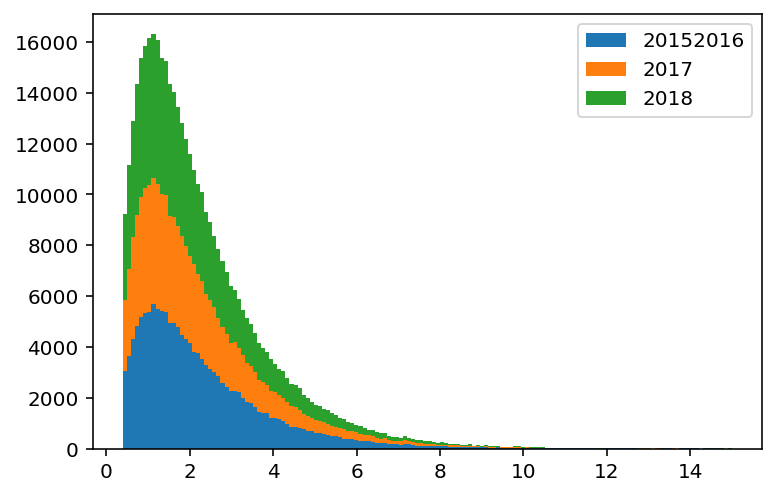

In [12]:
plt.figure(dpi=144)
times = [df[df.year == i].BeautyTime for i in range(3)]
weights = [df[df.year == i].sw for i in range(3)]
plt.hist(times, weights=weights, bins=150, histtype='barstacked', label=['20152016', '2017', '2018'])
plt.legend(loc='best')
plt.show()

In [13]:
timerange = (0.4, 15)

In [14]:
rwidth = RooRealVar('rwidth', 'rwidth', 0.045)
rmean = RooRealVar('rmean', 'rmean', 0)
time = RooRealVar('time', 'time', *timerange)
tau = RooRealVar('tau', 'tau', 1 / 0.663)

In [15]:
resolution = RooGaussModel('resolution', 'resolution', time, rmean, rwidth)
timepdf = RooDecay('timepdf', 'timepdf', time, tau, resolution, RooDecay.SingleSided)

In [16]:
xs = np.linspace(0.4, 15, 300)

In [17]:
def pdf(xs):
    global timepdf
    global time
    timeys = []
    for x in xs:
        time.setVal(x)
        timeys.append(timepdf.getVal())
    return np.array(timeys)

In [18]:
timeys = pdf(xs)

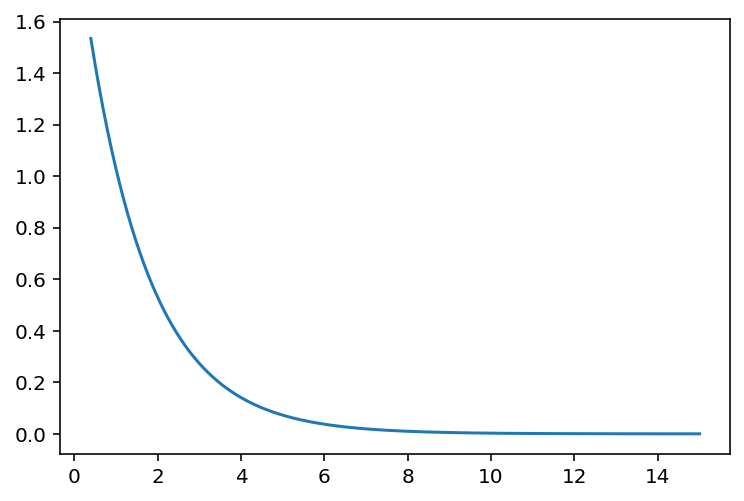

In [19]:
plt.figure(dpi=144)
plt.plot(xs, timeys)

In [20]:
t = 3 * [timerange[0]] + [0.5, 1, 2, 3, 12] + 3 * [timerange[1]]
c = [0.34, 0.52, 0.9, 1.05, 1.2, 1.0, 0.92]
k = 3

In [21]:
spl = BSpline(t, c, k)

In [22]:
spl.basis_element(t[:4])

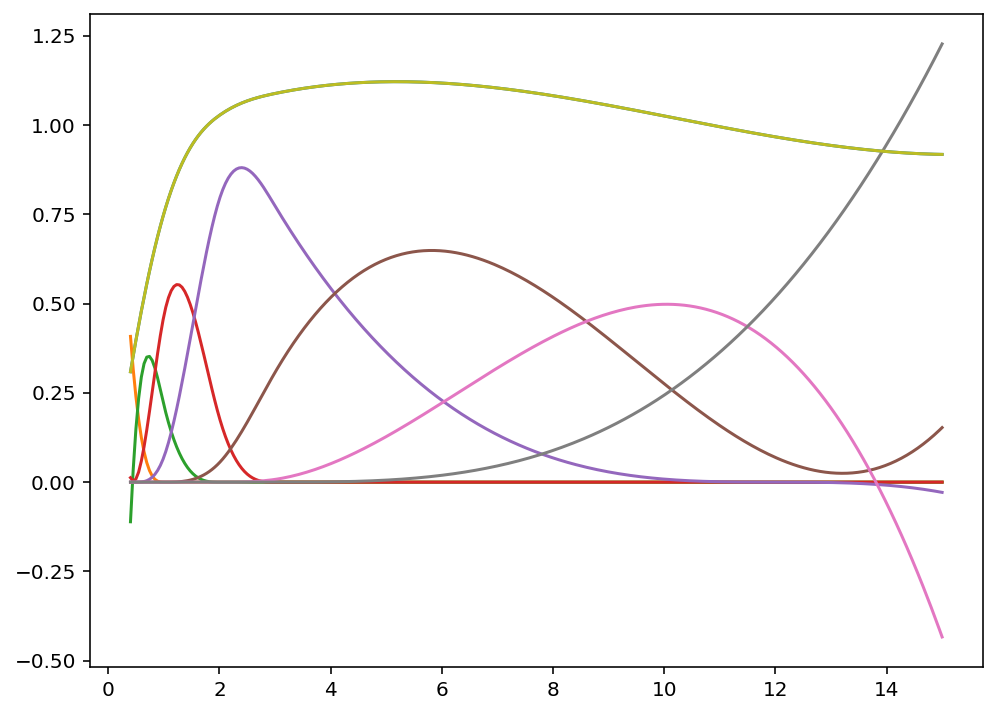

In [23]:
plt.figure(figsize=(8, 6), dpi=144)
plt.plot(xs, spl(xs))
spl_sum = []
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = BSpline(t, subc, k)
    plt.plot(xs, subspl(xs))
    spl_sum.append(subspl(xs))
plt.plot(xs, np.sum(spl_sum, axis=0))

In [24]:
class Foo():
    def __call__(self):
        print('called')

In [25]:
def splineGen(t, c, k=3, impl='scipy'):
    if impl == 'scipy':
        return BSpline(t, c, k)
    elif impl == 'root':
        class RooSpline():
            def __init__(self, t, c, *args):
                self.x = RooRealVar('x', 'x', 0)
                self.rooCoeffList = [
                    RooRealVar(f'c{i}', f'c{i}', cv) for i, cv in enumerate(c)
                ]
                self.t = ROOT.std.vector('double')()
                for tv in t[3:-3]:
                    self.t.push_back(tv)
                self.coeffs = RooArgList()
                for c in self.rooCoeffList:
                    self.coeffs.add(c)
                if self.t.size() + 2 == self.coeffs.getSize():
                    self.spline = RooCubicSplineFun('spline', 'spline', self.x, self.t, self.coeffs)
                else:
                    raise ValueError('Inconsistent knots and splines for cubic BSpline')
                
            def __call__(self, xs):
                ys = []
                if type(xs) not in [np.array, np.ndarray, list]:
                    xs = [xs]
                for x in xs:
                    self.x.setVal(x)
                    ys.append(self.spline.getVal())
                return np.array(ys)
                
        return RooSpline(t, c)

In [26]:
type(xs) in [np.array, np.ndarray]

True

In [27]:
def splinomat(t, c, k=3, xmax=6, impl='scipy'):
    spl = splineGen(t, c, k, impl=impl)

    plt.figure(dpi=144)
    hist, bins, _ = plt.hist(df.BeautyTime, weights=df.sw, bins=150)
    binwidth = bins[1] - bins[0]
    scale = binwidth * hist.sum() / trapz(spl(xs) * timeys, xs)
    plt.plot(xs, spl(xs) * timeys * scale)
    plt.vlines(t, 0, plt.ylim()[1] * 0.9, linestyle='--', color='grey')
    for i in range(len(c)):
        subc = np.zeros_like(c)
        subc[i] = c[i]
        subspl = splineGen(t, subc, k, impl='root')
        ys = subspl(xs) * timeys * scale
        plt.plot(xs, ys)
        if xs[ys.argmax()] < xmax:
            plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+2}')
    plt.ylim(bottom=0)
    plt.xlim(0, xmax)
    ax1 = plt.gca()
    plt.gca().twinx()
    plt.plot(xs, spl(xs), 'C2--')
    ax2 = plt.gca()
    f = plt.gcf()
    return f, ax1, ax2

(1, 17465.80089963939)

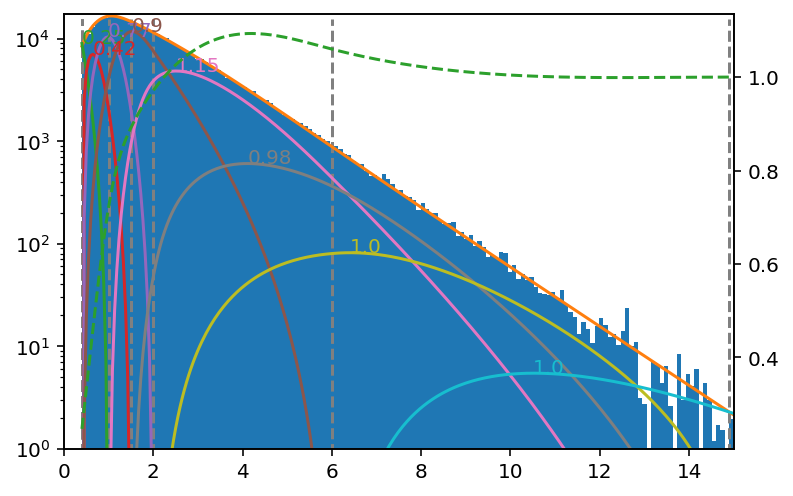

In [28]:
f, a1, a2 = splinomat(
    3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]],
    [0.25, 0.42, 0.77, 0.9, 1.15, 0.98, 1.0, 1.0],
    xmax=15,
)
a1.set_yscale('log')
a1.set_ylim(bottom=1)

(1, 19306.66439547477)

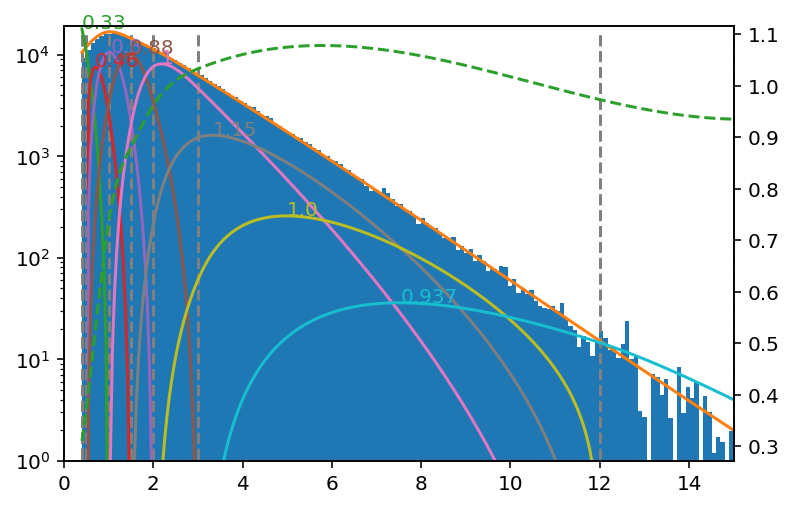

In [29]:
f, a1, a2 = splinomat(
    3 * [timerange[0]] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [timerange[1]],
    [0.33, 0.46, 0.8, 0.88, 1, 1.15, 1.0, 0.937],
    xmax=15
)
a1.set_yscale('log')
a1.set_ylim(bottom=1)

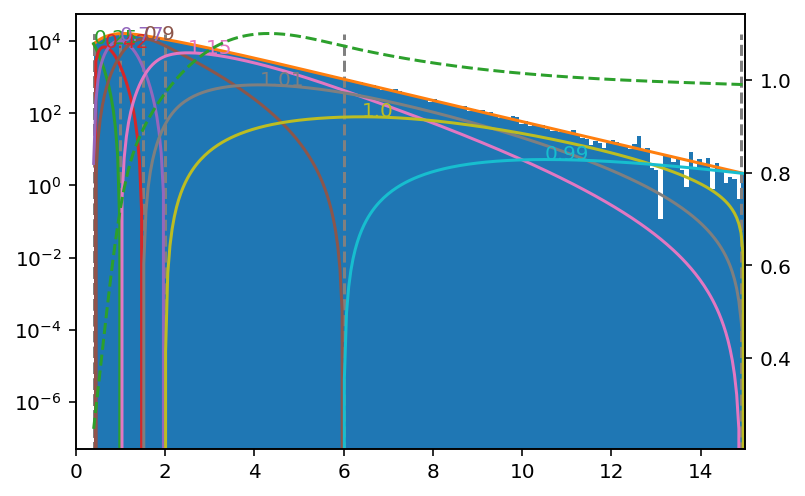

In [30]:
t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]
c = [0.25, 0.42, 0.77, 0.9, 1.15, 1.01, 1.0, 0.99]
k = 3

spl = BSpline(t, c, k)

xmax = 15

plt.figure(dpi=144)
hist, bins, _ = plt.hist(df.BeautyTime, weights=df.sw, bins=150)
binwidth = bins[1] - bins[0]
scale = binwidth * hist.sum() / trapz(spl(xs) * timeys, xs)
plt.plot(xs, spl(xs) * timeys * scale)
plt.vlines(t, 0, plt.ylim()[1] * 0.9, linestyle='--', color='grey')
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = BSpline(t, subc, k)
    ys = subspl(xs) * timeys * scale
    plt.plot(xs, ys)
    if xs[ys.argmax()] < xmax:
        plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+2}')
# plt.ylim(bottom=0)
plt.xlim(0, xmax)
plt.yscale('log')
plt.gca().twinx()
plt.plot(xs, spl(xs), 'C2--')


In [31]:
hist, bins = np.histogram(df.BeautyTime, bins=110)
low, high = poisson.interval(0.682, hist)
low / hist, high / hist
rolling_low = pd.DataFrame(low / hist).rolling(30).mean()
lowf = interp1d(bins[10:-1] + (bins[1] - bins[0]) / 2, rolling_low[0][10:])

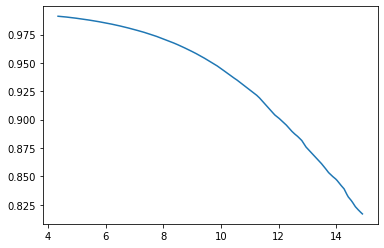

In [32]:
plt.plot(xs[(xs > lowf.x.min()) & (xs < lowf.x.max())], lowf(xs[(xs > lowf.x.min()) & (xs < lowf.x.max())]))

In [33]:
def filled(t=3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15],
           mean_c=[0.25, 0.42, 0.77, 0.9, 1.15, 1.01],
           cov=None, lastknot=1, label='', normrange=(0, 6), mock_uncertainty_from=None,
           impl='scipy', **kwargs):
    if cov is None:
        cov = np.array(len(mean_c) * [len(mean_c) * [0.75 * 0.02]])
        np.fill_diagonal(cov, 0.02)

    cs = np.random.multivariate_normal(mean_c, cov, size=500)

    xs = np.linspace(0.4, 15, 300)

    cs[0:5]

    ys = [splineGen(t, np.append(c, [1, lastknot]), k, impl=impl)(xs) for c in cs]

    splys = splineGen(t, np.append(mean_c, [1, lastknot]), k, impl=impl)(xs)
    normmask = (xs > normrange[0]) & (xs < normrange[1])
    norm = trapz(splys[normmask], xs[normmask])
    plt.plot(xs, splys / norm, label=label, **kwargs)
    low, high = np.percentile(ys, [15.9, 84.1], axis=0)
    if mock_uncertainty_from is not None:
        hist, bins = np.histogram(mock_uncertainty_from, bins=110)
        low_mock, high_mock = poisson.interval(0.682, hist)
        rolling_low = pd.DataFrame(low_mock / hist).rolling(10).mean()
        lowf = interp1d(bins[10:-1] + (bins[1] - bins[0]) / 2, rolling_low[0][10:])
        func_diff = splys - low
        # print(func_diff)
        # low -= splys - np.sqrt((splys - low_mock) ** 2 + ((1 - lowf(xs)) * splys) ** 2)
    plt.fill_between(xs, low / norm, high / norm, alpha=0.2, **kwargs)

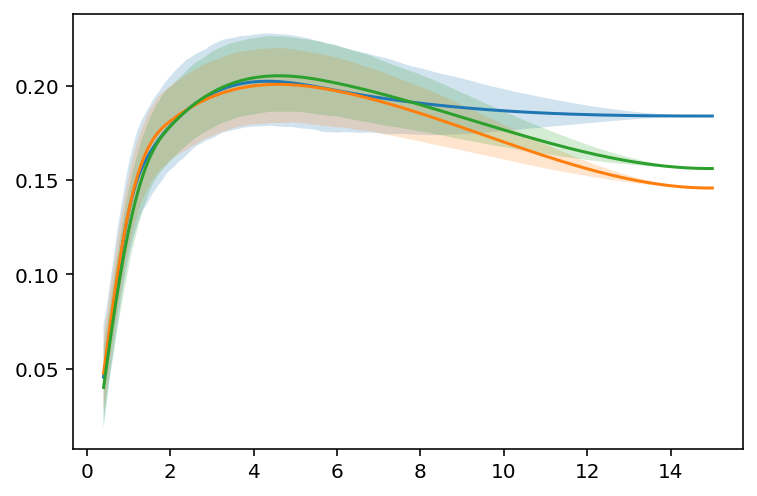

In [34]:
plt.figure(dpi=144)
t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]
filled(t, mock_uncertainty_from=df.BeautyTime)
filled(t, mean_c=[0.33, 0.56, 0.95, 1.18, 1.40, 1.38])
filled(t, mean_c=[0.26, 0.47, 0.81, 1.06, 1.35, 1.29])

In [266]:
def get_c_cov(fitresult, crange=[], y='20152016'):
    cov = np.array(len(crange) * [len(crange) * [0.0]])
    if y:
        y = '_' + y
    else:
        y = ''
    for mi, i in enumerate(crange):
        for mj, j in enumerate(crange):
            if i == j:
                print(f'var{i}{y}')
                cov[mi, mj] = fitresult.floatParsFinal().find(f'var{i}{y}').getError() ** 2
            else:
                cov[mi, mj] = cov[mj, mi] = (
                    fitresult.correlation(f'var{i + 1}_{y}', f'var{j}{y}')
                    * fitresult.floatParsFinal().find(f'var{i}{y}').getError()
                    * fitresult.floatParsFinal().find(f'var{j}{y}').getError()
                )
    c = [fitresult.floatParsFinal().find(f'var{i}{y}').getVal() for i in crange]
    return c, cov

In [36]:
def get_coeff(max, t0, t1, c):
    c2 = 1 - (max - t1) / (t0 - t1)
    c1 = (max - t1) / (t0 - t1)
    return c1 * c[-2] + c2 * c[-1]

In [37]:
oldknotsrf = ROOT.TFile('/Users/kheinicke/playground/WS_sFit_noglm_all_fitresult.root')
oldknotsr = oldknotsrf.Get('fitresult')

In [38]:
normrange = np.percentile(df.BeautyTime, [2.5, 97.5])
normrange

array([0.49665964, 6.33669004])

In [39]:
from matplotlib.colors import to_rgba

0.9074044598885643
0.9488053283940483
0.9086740039097265


(0.4, 15)

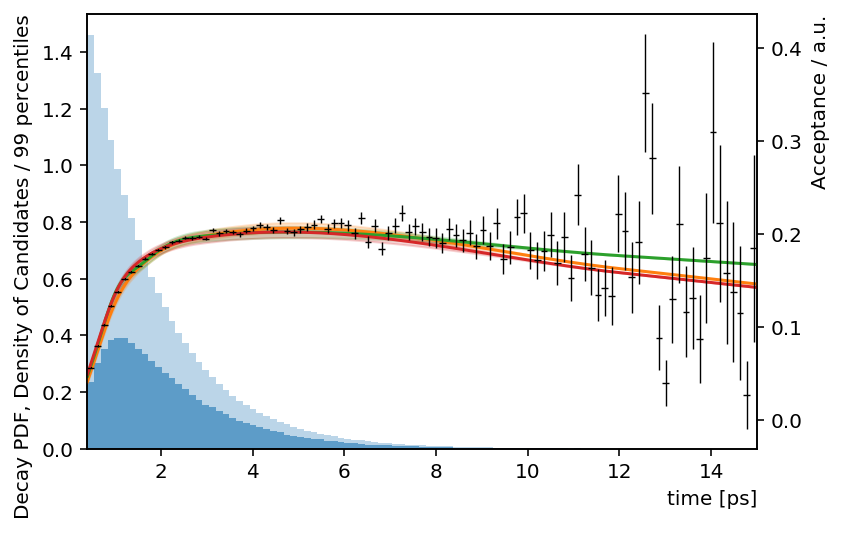

In [40]:
plt.figure(dpi=144)
timeys = []
# bins = np.percentile(df.BeautyTime, np.linspace(0, 100, 50))
bins = np.linspace(0.4, 15, 100)
hist, _ = np.histogram(df.BeautyTime, bins=bins, weights=df.sw, density=True)
absolute_hist, _ = np.histogram(df.BeautyTime, bins=bins, weights=df.sw)
binwidth = bins[1:] - bins[:-1]
bincenters = bins[:-1] + binwidth / 2
for x in bincenters:
    time.setVal(x)
    timeys.append(timepdf.getVal())
timeys = np.array(timeys)
plt.bar(bincenters, timeys, binwidth, color=to_rgba('C0', 0.3))
plt.bar(bincenters, hist, binwidth, color=to_rgba('C0', 0.6))
plt.ylabel(f'Decay PDF, Density of Candidates / {len(binwidth)} percentiles', ha='right', y=1)
plt.xlabel('time [ps]', ha='right', x=1)
plt.ylim(bottom=0)
# plt.yscale('log')

plt.gca().twinx()
normrange = (bincenters > 0.5) & (bincenters < 6)
scale = trapz((hist / timeys)[normrange], bincenters[normrange])
yerr_rel = np.sqrt(absolute_hist) / absolute_hist
plt.errorbar(
    bincenters,
    hist / timeys / scale, xerr=binwidth / 2,
    yerr=yerr_rel * hist / timeys / scale,
    fmt=',',
    zorder=1,
    linewidth=0.7,
    color='k')

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

for i, y in enumerate(['20152016', '2017', '2018']):
    c, cov = get_c_cov(oldknotsr, y=y)
    lastknot = get_coeff(15, t[-5], t[-4], c + [1])
    print(lastknot)
    filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label=y, normrange=(0.5, 6), impl='root',
           color=f'C{i + 1}', zorder=0)
# plt.ylim(0.05, 0.2)
plt.ylabel('Acceptance / a.u.', ha='right', y=1)
plt.xlim(0.4, 15)

0.9074044598885643
0.9488053283940483
0.9086740039097265


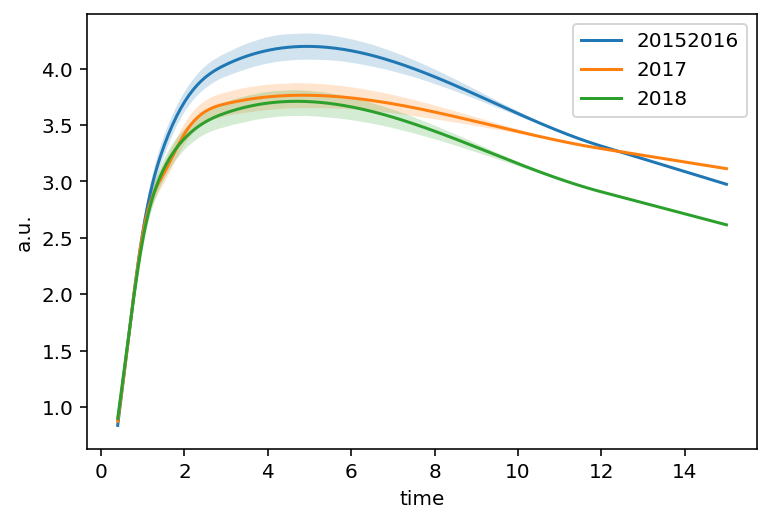

In [41]:
plt.figure(dpi=144)

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

c, cov = get_c_cov(oldknotsr)
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016', normrange=normrange, impl='root')

c, cov = get_c_cov(oldknotsr, y='2017')
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='2017', normrange=normrange, impl='root')

c, cov = get_c_cov(oldknotsr, y='2018')
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='2018', normrange=normrange, impl='root')

# plt.xlim(left=0.5)
# plt.ylim(bottom=0.05)
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('a.u.')
# plt.yscale('log')

# plt.gca().twinx()
# plt.hist(df.BeautyTime, weights=df.sw, bins=100, color='C1', histtype='step')
# plt.ylabel('Candidates')
# plt.yscale('log')
plt.show()

0.9074044598885643


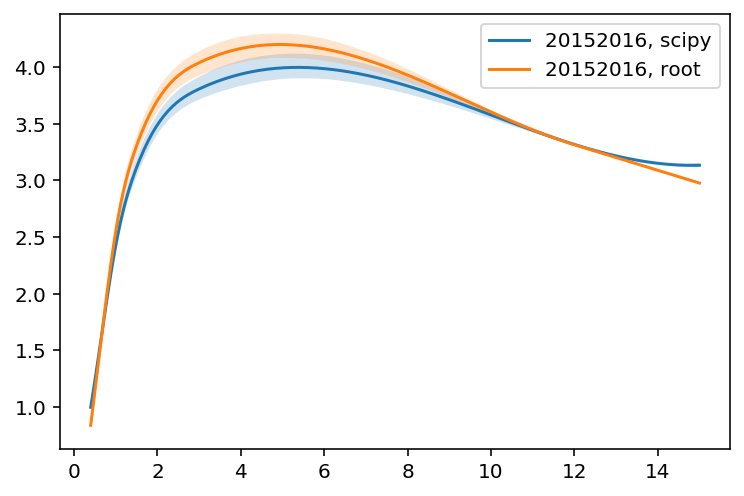

In [42]:
plt.figure(dpi=144)

t = 3 * [0.4] + [0.5, 1., 1.5, 2., 3, 12] + 3 * [15]

c, cov = get_c_cov(oldknotsr)
lastknot = get_coeff(15, t[-5], t[-4], c + [1])
print(lastknot)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016, scipy', normrange=normrange)
filled(t=t, mean_c=c, cov=cov, lastknot=lastknot, label='20152016, root', normrange=normrange, impl='root')
plt.legend(loc='best')

In [43]:
newknotsrf = ROOT.TFile('/Users/kheinicke/playground/WS_sFit_noglm_newknots_all_fitresult.root')
newknotsr = newknotsrf.Get('fitresult')

(0.05, 4.707174343440687)

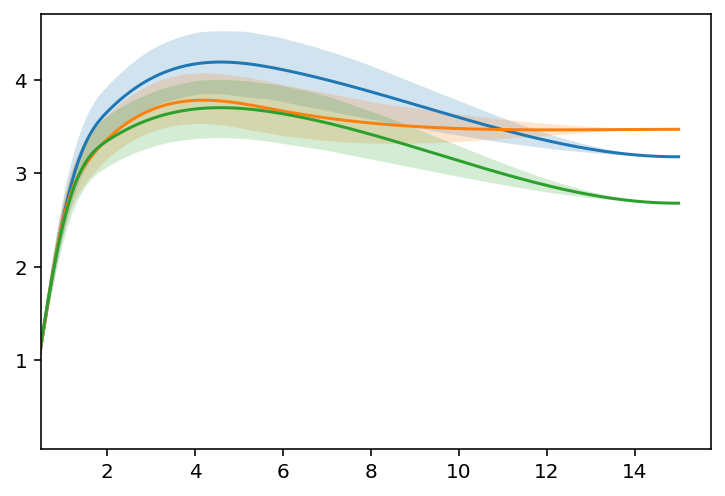

In [44]:
plt.figure(dpi=144)

t = 3 * [timerange[0]] + [0.41, 1., 1.5, 2., 6., 14.9] + 3 * [timerange[1]]

c, cov = get_c_cov(newknotsr)
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

c, cov = get_c_cov(newknotsr, y='2017')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

c, cov = get_c_cov(newknotsr, y='2018')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange)

plt.xlim(left=0.5)
plt.ylim(bottom=0.05)

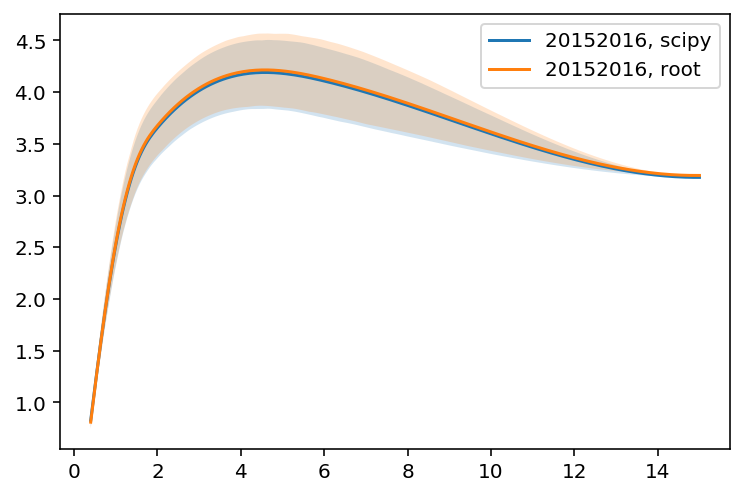

In [45]:
plt.figure(dpi=144)
c, cov = get_c_cov(newknotsr)
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange, label='20152016, scipy')
filled(t=t, mean_c=c, cov=cov, lastknot=1, normrange=normrange, label='20152016, root', impl='root')
plt.legend(loc='best')

In [46]:
weight = ROOT.RooRealVar('weight', 'weight', -1, 1)
datasetVars = ROOT.RooArgSet(time, weight)
dataset = ROOT.RooDataSet('dataset', 'dataset', datasetVars, 'weight')

In [47]:
for tval, sw in tqdm(df[['BeautyTime', 'sw']].values):
    time.setVal(tval)
    dataset.add(datasetVars, sw)

In [241]:
print(c, t)

[1, 1, 1, 1, 1, 1, 1, 1] [0.4, 0.4, 0.4, 0.5, 1, 1.5, 2, 3, 12, 15, 15, 15]


In [244]:
# t = [0.4, 0.4, 0.4, 0.5, 1.5, 2, 3, 4, 10, 15, 15, 15]  # new try
t = [0.4, 0.4, 0.4, 0.5, 1, 1.5, 2, 3, 12, 15, 15, 15]  # classic positions
# t = [0.4, 0.4, 0.4, 0.41, 1, 1.5, 2, 6, 14.9, 15, 15, 15]  # "newknots"

In [270]:
cfit = np.ones_like(t[2:-2])
coefflist = ROOT.RooArgList()
coeffRootList = []
for i, cval in enumerate(cfit):
    coeffRootList.append(ROOT.RooRealVar(f'var{i}', f'var{i}', cval, 0, 2))
    if i in [6]:
        coeffRootList[-1].setConstant(True)
    coefflist.add(coeffRootList[-1])
knots = ROOT.std.vector('double')()
for tval in t[3:-3]:
    knots.push_back(tval)

In [271]:
coefflist.size()

8

In [272]:
knots.size() + 2 == coefflist.size()

True

In [273]:
print(knots, coefflist)
coefflist.Print()
print(len(knots), len(cfit))

{ 0.50000000, 1.0000000, 1.5000000, 2.0000000, 3.0000000, 12.000000 } { @0x7ff89fd5bc10, @0x7ff89fd5bc18, @0x7ff89fd5bc20, @0x7ff89fd5bc28, @0x7ff89fd5bc30, @0x7ff89fd5bc38, @0x7ff89fd5bc40, @0x7ff89fd5bc48 }
6 8
RooArgList:: = (var0,var1,var2,var3,var4,var5,var6,var7)


In [274]:
acceptancepdf = ROOT.RooCubicSplineFun('acc', 'acc', time, knots, coefflist)
efficiencymodel = ROOT.RooGaussEfficiencyModel('trm', 'trm', time, acceptancepdf, rmean, rwidth)
fullpdf = ROOT.RooDecay('fullpdf', 'fullpdf', time, tau, efficiencymodel, ROOT.RooDecay.SingleSided)

In [275]:
xs = np.linspace(0.4, 15, 300)
ys = []
for x in xs:
    time.setVal(x)
    ys.append(fullpdf.getVal())

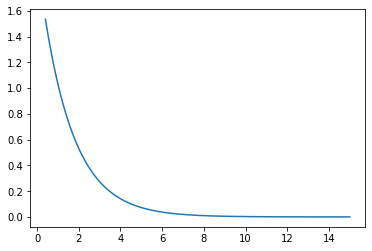

In [276]:
plt.plot(xs, ys)

In [277]:
fitresult = fullpdf.fitTo(dataset, ROOT.RooFit.NumCPU(6), ROOT.RooFit.Verbose(True), ROOT.RooFit.Save(True))

[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(fullpdf) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an'n       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
           - Or provide AsymptoticError(true), to use the asymptotically correct expression
             (for details see https://arxiv.org/abs/1911.01303).
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activatin

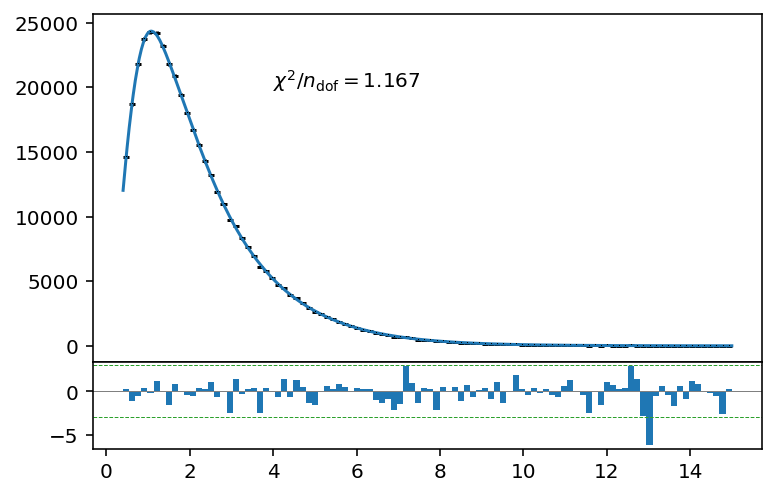

In [278]:
plt.figure(dpi=144)
a1 = plt.subplot2grid((5, 1), (0, 0), rowspan=4)

hist, bins = np.histogram(df.BeautyTime, weights=df.sw, bins=100)
binwidth = bins[1] - bins[0]
bincenters = bins[1:] - binwidth / 2
plt.errorbar(bincenters, hist, yerr=np.sqrt(hist), xerr=binwidth / 2, fmt=',', color='k')

xs = np.sort(np.concatenate((np.linspace(0.4, 15, 300), bincenters)))
ys = []
for x in xs:
    time.setVal(x)
    ys.append(fullpdf.getVal())
ys = np.array(ys)
scale = hist.sum() / trapz(ys, xs) * binwidth
plt.plot(xs, ys * scale)
# plt.yscale('log')

plt.subplot2grid((5, 1), (4, 0), sharex=a1)
pulls = []
chi2 = 0
for x, h in zip(bincenters, hist):
    time.setVal(x)
    pulls.append((h - fullpdf.getVal() * scale) / np.sqrt(h))
    chi2 += (h - fullpdf.getVal() * scale)**2 / (fullpdf.getVal() * scale)
chi2ndof = chi2 / (len(hist) - 1 + len(c))
plt.bar(bincenters, pulls, width=binwidth)
plt.axhline(3, linewidth=0.5, color='C2', linestyle='--')
plt.axhline(-3, linewidth=0.5, color='C2', linestyle='--')
plt.axhline(0, linewidth=0.5, color='0.5')
plt.subplots_adjust(hspace=0)
plt.sca(a1)
plt.text(4, 20000, f'$\\chi^2/n_\\mathrm{{dof}} = {chi2ndof:.3f}$')
plt.savefig('/Users/kheinicke/playground/oldfixpenultimateknots.pdf')

In [279]:
fitresult

<ROOT.RooFitResult object ("fitresult_fullpdf_dataset") at 0x7ff8a1a80c30>

In [282]:
cfit, cov = get_c_cov(fitresult, y='', crange=range(1, 6))

var1
var2
var3
var4
var5
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var2_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var2_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var2_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var2_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var3_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var3_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_fullpdf_dataset) parameter var3_ is not a floating fit parameter
[#0] ERROR:InputArguments -- RooFitResult::correlation(fitresult_

In [283]:
filled(t, mean_c=cfit, cov=cov)

ValueError: Knots, coefficients and degree are inconsistent.

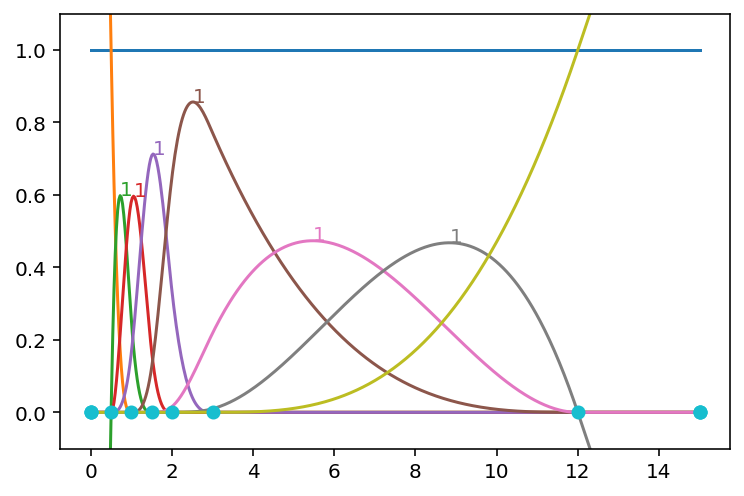

In [199]:
plt.figure(dpi=144)
xs = np.linspace(0.0, 15, 500)
t = [0.0, 0.0, 0.0, 0.5, 1, 1.5, 2, 3, 12, 15, 15, 15]
c = (len(t) - 4) * [1]
k = 3
spline = splineGen(t, c, k, impl='root')
plt.plot(xs, spline(xs))
plt.ylim(-0.1, 1.1)
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = splineGen(t, subc, k, impl='root')
    ys = subspl(xs)
    plt.plot(xs, ys)
    if xs[ys.argmax()] < xmax and plt.ylim()[0] < ys.max() < plt.ylim()[1]:
        plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+1}')
plt.plot(t, np.zeros_like(t), 'o')

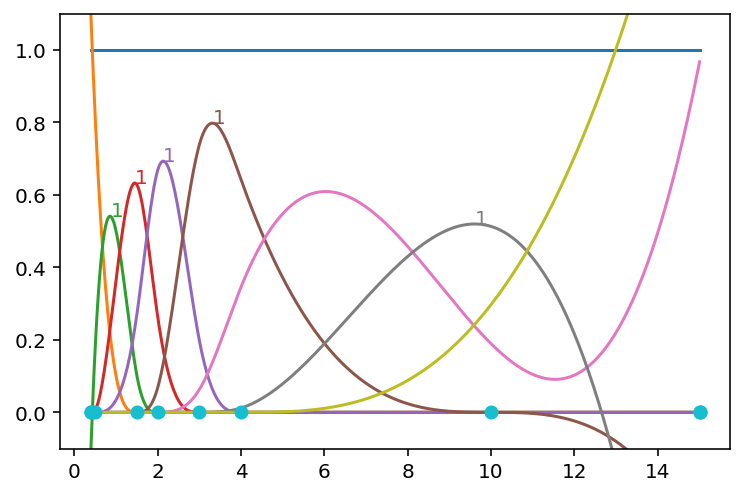

In [94]:
plt.figure(dpi=144)
xs = np.linspace(0.4, 15, 500)
t = [0.4, 0.4, 0.4, 0.5, 1.5, 2, 3, 4, 10, 15, 15, 15]
c = 8 * [1]
k = 3
impl = 'scipy'
spline = splineGen(t, c, k, impl=impl)
plt.plot(xs, spline(xs))
plt.ylim(-0.1, 1.1)
for i in range(len(c)):
    subc = np.zeros_like(c)
    subc[i] = c[i]
    subspl = splineGen(t, subc, k, impl=impl)
    ys = subspl(xs)
    plt.plot(xs, ys)
    if xs[ys.argmax()] < xmax and plt.ylim()[0] < ys.max() < plt.ylim()[1]:
        plt.text(xs[ys.argmax()], ys.max(), str(c[i]), color=f'C{i+1}')
plt.plot(t, np.zeros_like(t), 'o')